In [1]:
import csv
import numpy as np
import multiprocessing as mp
import random
import matplotlib.pyplot as plt
import pickle
import pandas as pd
#import tensorflow as tf
import json
from sklearn.model_selection import train_test_split
import math

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir='../data/Current Data/'

In [3]:
CategoricalFeatures=[]
NumericFeatures=[]

demographics

In [4]:
df_demographics=pd.read_csv(data_dir+'REACT_Demographics'+'.csv')
#df_demographics.info()

In [5]:
#df_demographics.head()

In [6]:
#df_demographics.columns

In [7]:
CategoricalFeatures+=['GENDER','ETHNIC_GROUP', 'SMOKING_HISTORY']
NumericFeatures+=['PATIENT_AGE']

In [8]:
studyid_data_dic=dict()
for studyid,age,gender,ethnic,smoking in df_demographics[['STUDY_ID','PATIENT_AGE','GENDER','ETHNIC_GROUP', 'SMOKING_HISTORY']].values:
    if age is not np.nan and gender is not np.nan and ethnic is not np.nan and smoking is not np.nan:
        if studyid not in studyid_data_dic:
            studyid_data_dic[studyid]=dict()
        studyid_data_dic[studyid]['PATIENT_AGE']=age
        studyid_data_dic[studyid]['GENDER']=str(gender)
        studyid_data_dic[studyid]['ETHNIC_GROUP']=ethnic
        studyid_data_dic[studyid]['SMOKING_HISTORY']=smoking
#studyid_data_dic

Comorbidities

In [9]:
df_comorbidities=pd.read_csv(data_dir+'REACT_Comorbidities_unpivoted'+'.csv')
#df_demographics.info()

In [10]:
comorbidities=list(df_comorbidities.COMORBIDITY.unique())
NumericFeatures+=comorbidities
for studyid in studyid_data_dic:
    for co in comorbidities:
        studyid_data_dic[studyid][co]=0

In [11]:
for studyid,co,status in df_comorbidities.values:
    if studyid in studyid_data_dic:
        studyid_data_dic[studyid][co]=status
#studyid_data_dic

label: RespiratorySupportRequired or not

In [12]:
df_Vitalsigns_Categorical=pd.read_csv(data_dir+'REACT_Vitalsigns_Categorical'+'.csv')
#df_Vitalsigns_Categorical.info()

In [13]:
#df_Vitalsigns_Categorical.head()

In [14]:
CategorySet=dict()
CategorySet[0]=set(['Air - Not Supported'])
CategorySet[1]=set([
    'Nasal Specs', 'Face Mask', 'Venturi Mask',
    'Non-Rebreath Mask', 'Invasive Ventilation', 'Optiflow / Hi Flow',
    'NIV - CPAP face mask', 'NIV - CPAP full face mask',
    'NIV - BIPAP face mask', 'NIV - CPAP nasal mask',
    'NIV - BIPAP nasal mask', 'NIV - BIPAP full face mask',
    'Trachy Mask'
])
CategoryDictionary=dict([(item,label) for label in CategorySet for item in CategorySet[label]])
CategoryDictionary

{'Air - Not Supported': 0,
 'Face Mask': 1,
 'NIV - CPAP face mask': 1,
 'Nasal Specs': 1,
 'NIV - CPAP full face mask': 1,
 'NIV - BIPAP full face mask': 1,
 'NIV - CPAP nasal mask': 1,
 'Trachy Mask': 1,
 'NIV - BIPAP face mask': 1,
 'Optiflow / Hi Flow': 1,
 'NIV - BIPAP nasal mask': 1,
 'Invasive Ventilation': 1,
 'Venturi Mask': 1,
 'Non-Rebreath Mask': 1}

In [15]:
df_label=df_Vitalsigns_Categorical[df_Vitalsigns_Categorical.PARAMETER=='Respiratory Support'][['STUDY_ID','UNITFROM_DATETIME','VALUE']]

In [16]:
from datetime import datetime

label_studyid_time_dic=dict()
for study_id,start_datetime,label in df_label.values:
    start_datetime=start_datetime.replace('.000','')#need to be fixed some datetime end with .000
    start_datetime=datetime.strptime(start_datetime,'%Y-%m-%d %H:%M:%S')
    label_category=CategoryDictionary[label]
    if study_id not in label_studyid_time_dic:
        label_studyid_time_dic[study_id]=[start_datetime,label_category]
    else:
        curr_start_datetime,curr_label_category=label_studyid_time_dic[study_id]
        if label_category>=curr_label_category and curr_start_datetime>start_datetime:
            label_studyid_time_dic[study_id]=[start_datetime,label_category]

#label_studyid_time_dic

In [17]:
for studyid in studyid_data_dic:
    if studyid not in label_studyid_time_dic:
        studyid_data_dic[studyid]['TIME_POINT']=None
        studyid_data_dic[studyid]['PREDICTION_LABEL']=0
    else:
        start_datetime,label_category=label_studyid_time_dic[studyid]
        studyid_data_dic[studyid]['TIME_POINT']=start_datetime
        studyid_data_dic[studyid]['PREDICTION_LABEL']=label_category

labresults

In [18]:
df_labresults=pd.read_csv(data_dir+'REACT_LabResults'+'.csv')
#df_labresults.info()

In [19]:
#df_labresults.head()

In [20]:
testcode_lst=list(df_labresults.REACT_TESTCODE.unique())
testcode2id=dict([(testcode_lst[i],i) for i in range(len(testcode_lst))])

In [21]:
from datetime import datetime

studyid_testcode_time_numeric_dic=dict()
for studyid,test_time,testcode,numeric,lower,upper in df_labresults[[
    'STUDY_ID','PATHOLOGY_SPECIMEN_DATE','REACT_TESTCODE',
    'PATHOLOGY_RESULT_NUMERIC','LOWER_RANGE','UPPER_RANGE']].values:
    test_time=datetime.strptime(test_time,'%Y-%m-%d %H:%M:%S')
    if studyid not in studyid_testcode_time_numeric_dic:
        studyid_testcode_time_numeric_dic[studyid]=[]
    studyid_testcode_time_numeric_dic[studyid].append([test_time,testcode,numeric])
#studyid_testcode_time_numeric_dic

In [22]:
NumericFeatures+=[testcode+suffix for testcode in testcode_lst for suffix in ['_MIN','_MAX','_MEAN']]

In [23]:
for studyid in studyid_data_dic:
    for testcode in testcode_lst:
        for suffix in ['_MIN','_MAX','_MEAN']:
            studyid_data_dic[studyid][testcode+suffix]=None
    time_point=studyid_data_dic[studyid]['TIME_POINT']
    if studyid in studyid_testcode_time_numeric_dic:
        individual_labresult_dic=dict()
        for test_time,testcode,numeric in studyid_testcode_time_numeric_dic[studyid]:
            if time_point is None or test_time<time_point:
                if testcode not in individual_labresult_dic:
                    individual_labresult_dic[testcode]=[]
                individual_labresult_dic[testcode].append(numeric)
        for testcode in individual_labresult_dic:
            studyid_data_dic[studyid][testcode+'_MIN']=np.min(individual_labresult_dic[testcode])
            studyid_data_dic[studyid][testcode+'_MAX']=np.min(individual_labresult_dic[testcode])
            studyid_data_dic[studyid][testcode+'_MEAN']=np.mean(individual_labresult_dic[testcode])

data preprocessing

In [24]:
studyid_lst=list(studyid_data_dic.keys())
#studyid_lst

In [25]:
X_cols=[]

In [26]:
from sklearn.preprocessing import OneHotEncoder

X_categorical=[[studyid_data_dic[studyid][k] for k in CategoricalFeatures] for studyid in studyid_lst]

enc = OneHotEncoder(handle_unknown='ignore')
X_onehot=enc.fit_transform(X_categorical).toarray()

X_cols+=list(enc.get_feature_names(CategoricalFeatures))

In [27]:
X_numeric=[[studyid_data_dic[studyid][k] for k in NumericFeatures] for studyid in studyid_lst]
X_cols+=NumericFeatures

In [28]:
X_missing_value=np.concatenate((X_onehot,X_numeric), axis=1)

In [29]:
Y=np.array([studyid_data_dic[studyid]['PREDICTION_LABEL'] for studyid in studyid_lst])

In [30]:
balance_ratio=len([_ for v in Y if v==0])/len([_ for v in Y if v==1])
balance_ratio

0.826865671641791

from functools import reduce

XY_missing_value_balanced=np.array(
    reduce(lambda a,b:a+b,[[list(x)+[y]]*(balance_ratio if y==1 else 1) for x,y in zip(X_missing_value,Y)])
)
#XY_missing_value_balanced

fill in nan

In [31]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

X=imputer.fit_transform(X_missing_value)

Prediction Classification task (RespiratorySupportRequired:1 or not:0)

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

models={
    "Logit":LogisticRegression(solver="lbfgs"),
    "MLP":MLPClassifier(max_iter=3000,solver='adam', alpha=1e-3,hidden_layer_sizes=(64)),
    "DecisionTree":DecisionTreeClassifier(),
    "RandomForest":RandomForestClassifier(n_estimators=100),
    "AdaBoost":AdaBoostClassifier(n_estimators=100),
    "GradientBoost":GradientBoostingClassifier(n_estimators=100),
    "XGBoost":XGBClassifier(n_estimators=100)
}

In [33]:
from sklearn.model_selection import KFold

from sklearn.metrics import average_precision_score

ap_result_lst=[]

kf = KFold(n_splits=10,shuffle=True)

n_class=2

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    Y_test = np.zeros([len(y_test),n_class])
    for i in range(len(y_test)):
        Y_test[i,y_test[i]]=1
    ap_result_lst.append(
        [average_precision_score(Y_test,models[model_name].fit(X_train,y_train).predict_proba(X_test))\
                for model_name in models])

print(pd.DataFrame(ap_result_lst,columns=[model_name for model_name in models]))

      Logit       MLP  DecisionTree  RandomForest  AdaBoost  GradientBoost  \
0  0.583222  0.487556      0.587994      0.607740  0.606802       0.670825   
1  0.474914  0.551142      0.464825      0.538360  0.455809       0.524012   
2  0.629779  0.436644      0.458333      0.506099  0.486531       0.559847   
3  0.499641  0.546458      0.522409      0.637140  0.553616       0.645147   
4  0.620917  0.497158      0.528268      0.607514  0.605609       0.638121   
5  0.530726  0.628891      0.574421      0.620536  0.673654       0.694402   
6  0.596644  0.516546      0.491212      0.603474  0.519937       0.622191   
7  0.595507  0.509332      0.483773      0.504303  0.518128       0.567418   
8  0.572326  0.552459      0.501137      0.569209  0.557782       0.599267   
9  0.516834  0.473954      0.518200      0.582084  0.540994       0.661421   

    XGBoost  
0  0.628285  
1  0.528910  
2  0.605741  
3  0.625542  
4  0.564646  
5  0.629162  
6  0.551720  
7  0.529479  
8  0.515814  
9

In [34]:
print(pd.DataFrame(np.mean(ap_result_lst,axis=0,keepdims=True),columns=[model_name for model_name in models]))

      Logit       MLP  DecisionTree  RandomForest  AdaBoost  GradientBoost  \
0  0.562051  0.520014      0.513057      0.577646  0.551886       0.618265   

    XGBoost  
0  0.580608  


In [35]:
class_names=['Not required','Required']

In [36]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver="lbfgs").fit(X, Y)

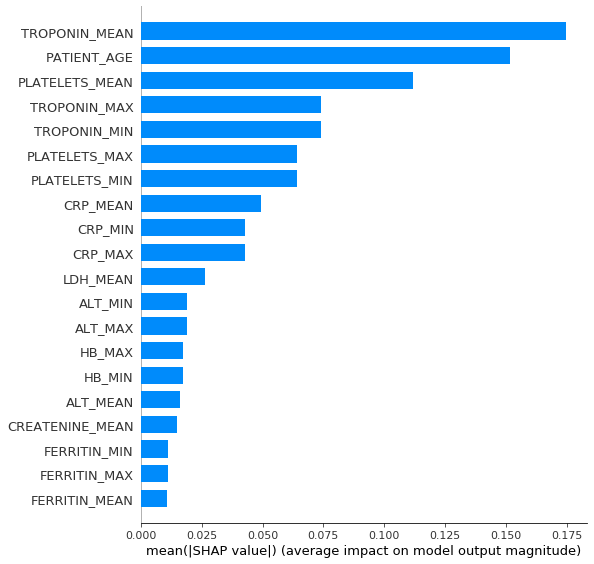

In [37]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.LinearExplainer(clf,X)
shap_values = explainer.shap_values(X)

# summarize the effects of all the features
shap.summary_plot(shap_values, X, feature_names=X_cols, plot_type="bar",class_names=class_names)

In [38]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier().fit(X, Y)

In [39]:
feature_importance_dic=dict(zip(X_cols,clf.feature_importances_))
from sklearn.feature_selection import SelectFromModel
for k,v in sorted(
    [(X_cols[i],feature_importance_dic[X_cols[i]]) for i in SelectFromModel(clf, prefit=True, max_features=20).get_support(indices=True)],
    key=lambda x:x[1],
    reverse=True
):
    print(k,':',v)

PATIENT_AGE : 0.27771860282289934
NEURAL_D : 0.03929573064194272
HYPERTENSION : 0.036402261359060585
CARDIAC_D : 0.035439807804372364
DIABETES : 0.03462936677939078
COPD : 0.03157749164163645
RENAL_D : 0.03031597629355016
OBESITY : 0.03025553919332684
ASTHMA : 0.027187818769204473
SMOKING_HISTORY_NR|NR : 0.02641590081512509
GENDER_1 : 0.025948951669896442
MAGLINANT_NEO : 0.02568794454233807
GENDER_2 : 0.02458845863747334
SMOKING_HISTORY_Never smoked|NR : 0.024145686874970894
ETHNIC_GROUP_A : 0.020073965478337077
RHEUMATO_D : 0.01860054023693588
GLUCOSE_MAX : 0.018385822444960755
SMOKING_HISTORY_Ex-smoker|NR : 0.01806257017632549
GLUCOSE_MEAN : 0.017597987125689673
LIVER_D : 0.017256253818983297


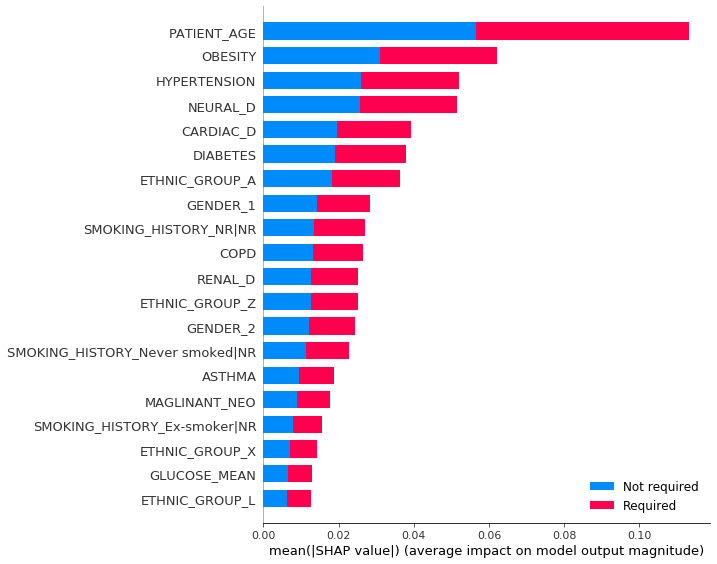

In [40]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

# summarize the effects of all the features
shap.summary_plot(shap_values, X, feature_names=X_cols, plot_type="bar",class_names=class_names)

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier().fit(X, Y)

In [42]:
feature_importance_dic=dict(zip(X_cols,clf.feature_importances_))
from sklearn.feature_selection import SelectFromModel
for k,v in sorted(
    [(X_cols[i],feature_importance_dic[X_cols[i]]) for i in SelectFromModel(clf, prefit=True, max_features=20).get_support(indices=True)],
    key=lambda x:x[1],
    reverse=True
):
    print(k,':',v)

PATIENT_AGE : 0.24870829498654234
GLUCOSE_MEAN : 0.08844546129713353
NEURAL_D : 0.04679215130887278
ETHNIC_GROUP_Z : 0.041089339129829275
OBESITY : 0.03803168341600215
ASTHMA : 0.03311126758298224
RENAL_D : 0.03101190999154903
COPD : 0.02651589826467356
ETHNIC_GROUP_L : 0.02630188537350871
ILD : 0.024877080203407675
ETHNIC_GROUP_S : 0.01924738081653906
DIABETES : 0.01743653304446573
IMMUNO : 0.014755595216498496
SMOKING_HISTORY_Current smoker|NR : 0.014636150769557535
CREATENINE_MIN : 0.014182699672461649
SODIUM_MEAN : 0.01355157456726943
BILIRUBIN_MEAN : 0.01289332633523639
ETHNIC_GROUP_X : 0.01251233541820085
ETHNIC_GROUP_C : 0.012065773905823068
RHEUMATO_D : 0.011882054027863896


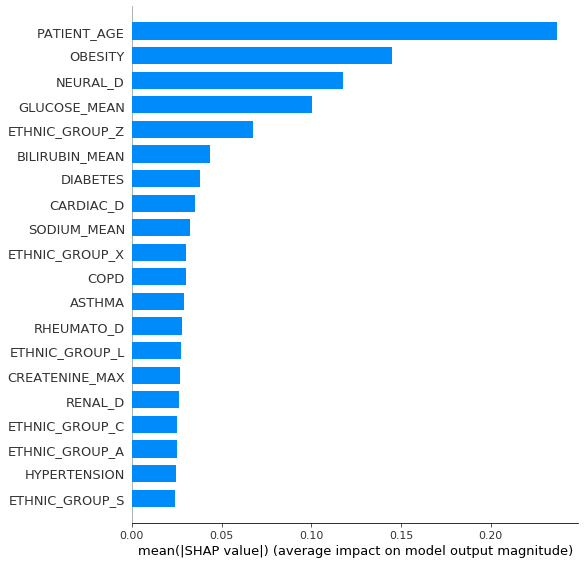

In [43]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

# summarize the effects of all the features
shap.summary_plot(shap_values, X, feature_names=X_cols, plot_type="bar",class_names=class_names)

In [44]:
from xgboost import XGBClassifier

clf = XGBClassifier(n_estimators=100).fit(X, Y)

In [45]:
feature_importance_dic=dict(zip(X_cols,clf.feature_importances_))
from sklearn.feature_selection import SelectFromModel
for k,v in sorted(
    [(X_cols[i],feature_importance_dic[X_cols[i]]) for i in SelectFromModel(clf, prefit=True, max_features=20).get_support(indices=True)],
    key=lambda x:x[1],
    reverse=True
):
    print(k,':',v)

ALT_MIN : 0.16034864
WBC_MEAN : 0.04870129
CREATENINE_MIN : 0.04562079
ETHNIC_GROUP_C : 0.034377027
HB_MIN : 0.033445846
SODIUM_MEAN : 0.03170896
ETHNIC_GROUP_Z : 0.030612946
NEUTROPHILS_MIN : 0.028748356
ETHNIC_GROUP_L : 0.028152417
SMOKING_HISTORY_Current smoker|NR : 0.02285521
OBESITY : 0.022820706
MAGLINANT_NEO : 0.021985097
NEUTROPHILS_MEAN : 0.020982755
WBC_MIN : 0.02086387
NEURAL_D : 0.020284457
POTASSIUM_MIN : 0.019693019
COPD : 0.018881176
PLATELETS_MEAN : 0.018659007
BILIRUBIN_MEAN : 0.018394057
RENAL_D : 0.017730942
